In [1]:
from fastai.imports import *
import seaborn as sns
import graphviz
from pickle import dump, load
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

# Dataset Preparation

In [2]:
df = pd.read_csv('./references/09 data clean.csv')
df.head()

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,...,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
0,7,1,17,3,3,2,4,1,1,3,...,0,0,0,1,1,1,3,0,0,0
1,9,1,15,1,5,1,4,1,1,3,...,0,1,0,1,1,0,3,0,0,0
2,11,1,14,1,1,1,2,1,1,3,...,0,1,1,1,1,0,1,0,0,0
3,15,1,15,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0
4,43,1,17,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0


In [3]:
cats=['religionnew', 'ethnicitynew', 'educationnew', 'occupationnew',
       'incomenew', 'maritalnew', 'smokenew', 'alcoholnew', 'partnernew',
       'EV', 'CB', 'PV', 'SV', 'IPV']
conts=['Age']
dep="MINIdepression"
# dep="Panxiety"
# dep="PPTSD"
for label in cats:
    df[label] = pd.Categorical(df[label])

In [4]:
df[dep].value_counts()

MINIdepression
1    50
0    41
Name: count, dtype: int64

## Save all plot in figures

## Split Dataset

In [4]:
trn_df,val_df = train_test_split(df, test_size=0.25)

In [5]:
trn_df[dep].value_counts()

MINIdepression
1    39
0    29
Name: count, dtype: int64

In [6]:
val_df[dep].value_counts()

MINIdepression
0    12
1    11
Name: count, dtype: int64

> The distribution between the dependent variable seem ok.

## Selecting Features

In [7]:
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [8]:
print(f'Training Shape: {trn_xs.shape}')
print(f'Validation Shape: {val_xs.shape}')

Training Shape: (68, 15)
Validation Shape: (23, 15)


> Bear in mind that the df is no longer categorical

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
trn_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
35,1,1,1,2,1,1,0,0,1,0,0,0,0,0,17
20,1,1,1,2,1,1,0,1,1,1,1,0,1,1,15
46,1,1,1,2,1,1,0,2,1,0,1,0,0,1,17
26,1,1,1,2,0,1,0,2,1,0,0,0,0,0,17
71,1,1,1,2,1,1,0,1,1,0,1,1,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,1,1,2,1,1,0,0,1,1,1,0,1,1,17
87,1,1,1,0,1,0,0,1,1,0,1,0,0,1,29
6,1,1,1,2,1,1,0,0,0,0,0,0,0,0,13
40,1,1,1,2,1,1,0,0,1,1,1,0,1,1,14


In [11]:
trn_y

35    1
20    1
46    1
26    0
71    0
     ..
57    1
87    0
6     0
40    1
33    1
Name: MINIdepression, Length: 68, dtype: int64

In [12]:
val_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
72,1,1,0,1,1,1,1,0,1,1,1,1,1,1,14
12,0,0,0,2,1,1,1,1,1,1,1,1,0,1,16
47,1,1,1,2,1,1,0,0,1,1,1,1,1,1,17
14,0,0,1,2,1,1,1,2,1,1,0,0,1,1,14
45,1,1,1,0,1,1,1,2,1,1,1,1,0,1,15
52,1,1,1,2,1,1,1,2,1,1,1,1,1,1,17
48,1,1,1,0,0,1,0,2,1,1,1,0,1,1,17
19,1,1,1,0,1,1,1,2,1,0,1,0,1,1,13
32,1,1,1,1,0,1,1,2,1,1,1,1,1,1,14
0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,17


In [13]:
val_y

72    1
12    1
47    0
14    1
45    0
52    1
48    0
19    1
32    1
0     0
51    0
11    0
44    1
86    0
23    1
59    1
66    0
63    0
36    0
22    1
21    1
60    0
88    0
Name: MINIdepression, dtype: int64

In [130]:
val_y.index

Index([72, 12, 47, 14, 45, 52, 48, 19, 32,  0, 51, 11, 44, 86, 23, 59, 66, 63,
       36, 22, 21, 60, 88],
      dtype='int64')

# Logistic Regression

## Model Training and Prediction

In [154]:
logreg = LogisticRegression()
logreg.fit(trn_xs, trn_y)

LogisticRegression()

## Model Evaluation

### MAE For Validation Set

In [155]:
y_pred = logreg.predict(val_xs)
mean_absolute_error(val_y, y_pred)

0.5217391304347826

### MAE For Training Set

In [156]:
y_train_pred = logreg.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.27941176470588236

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

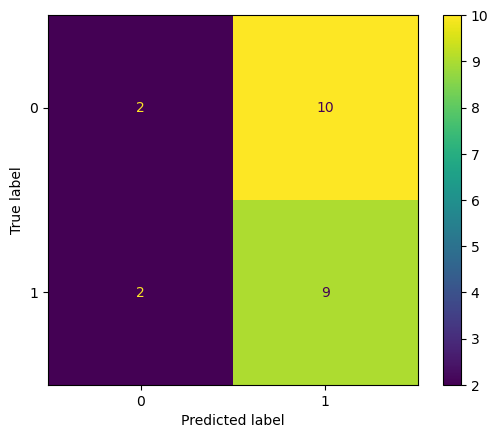

In [157]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is not very confidence in classifying if a subject is depressed or not. If the purple boxes is more towards zero, the better it is since that means the model did never guessed wrong.

### Accuracy, Precision, Recall

In [158]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4782608695652174
Precision: 0.47368421052631576
Recall: 0.8181818181818182


Accuracy: In general, when the model makes prediction, it is right 57% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

### Classification Report

In [159]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

                        precision    recall  f1-score   support

without MINIdepression       0.50      0.17      0.25        12
   with MINIdepression       0.47      0.82      0.60        11

              accuracy                           0.48        23
             macro avg       0.49      0.49      0.42        23
          weighted avg       0.49      0.48      0.42        23



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

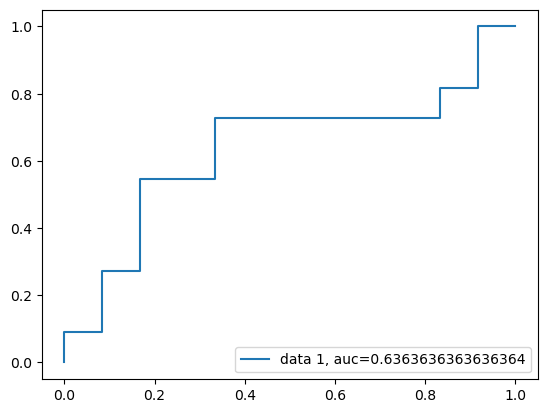

In [160]:
y_pred_proba = logreg.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.56. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.

### Feature Importance

#### By Training Set

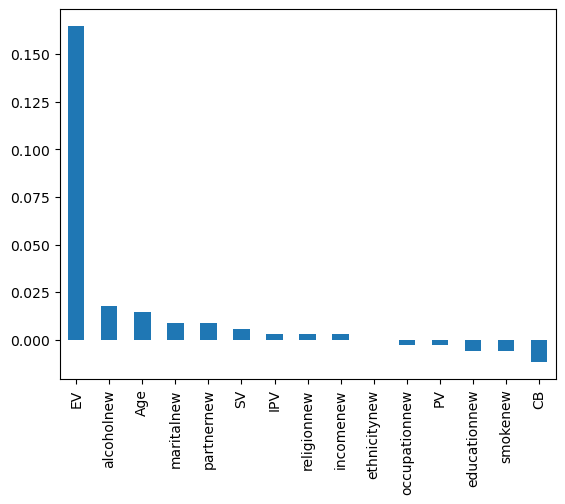

In [161]:
logreg_fi = permutation_importance(logreg, trn_xs, trn_y)
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(logreg_fi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.04 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

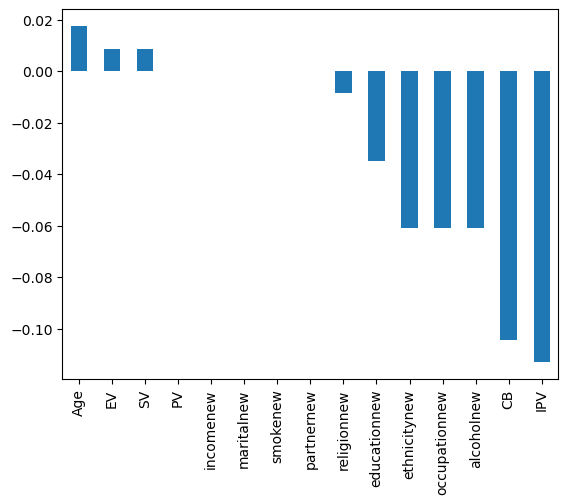

In [177]:
logreg_fi_val = permutation_importance(logreg, val_xs, val_y)

feature_importances = pd.Series(logreg_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

> Bear in mind that this model is not considered a good model by our Evaluation above (eg. AUC Score). So we cannot say for certain that the feature importance found above has a significant value to our conclusion. However we can still take it onto our consideration for further analysis.

> Also bear in mind, we get different result each time we refresh the code due to the randomness. However I found that EV is always on top of the other feature in importance.

#### Playground To Rerun

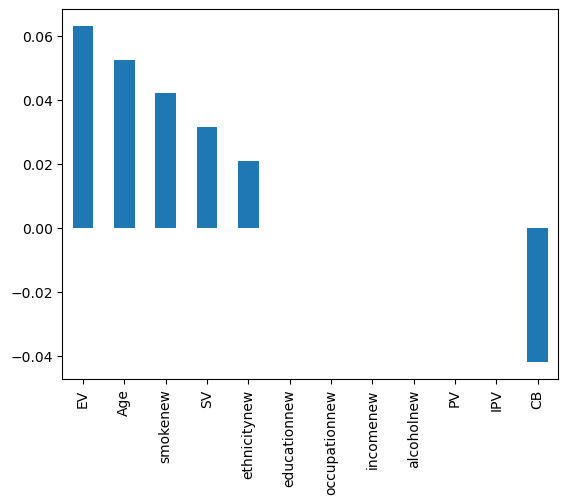

In [20]:
logreg_fi_val = permutation_importance(logreg, val_xs, val_y)

feature_importances = pd.Series(logreg_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

---

# Random Forest

## Model Training and Prediction

In [112]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)

## Model Evaluation

### MAE For Validation Set

In [113]:
y_pred = rf.predict(val_xs)
mean_absolute_error(val_y, y_pred)

0.34782608695652173

### MAE For Training Set

In [114]:
y_train_pred = rf.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.3382352941176471

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

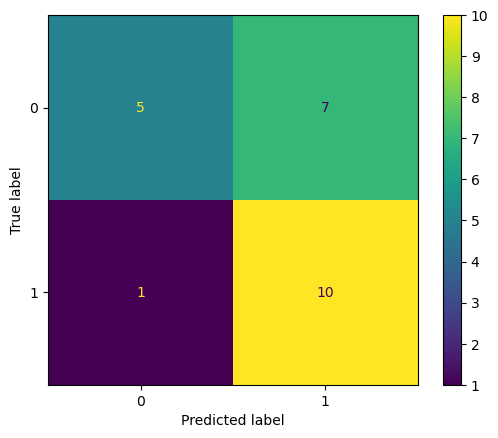

In [115]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is not very confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [116]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6521739130434783
Precision: 0.5882352941176471
Recall: 0.9090909090909091


Accuracy: In general, when the model makes prediction, it is right 63% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

### Classification Report

In [117]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

                        precision    recall  f1-score   support

without MINIdepression       0.83      0.42      0.56        12
   with MINIdepression       0.59      0.91      0.71        11

              accuracy                           0.65        23
             macro avg       0.71      0.66      0.63        23
          weighted avg       0.72      0.65      0.63        23



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

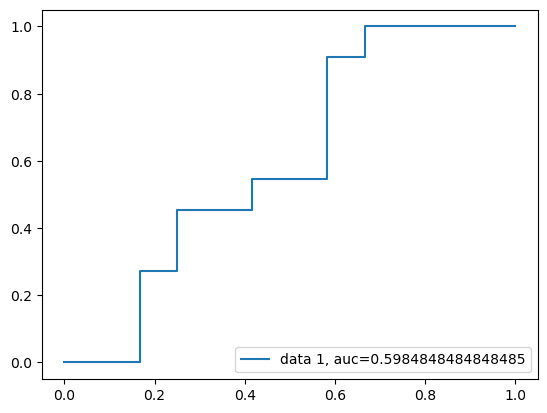

In [118]:
y_pred_proba = rf.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.56. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.
> This is slighly better than the Logistic Regression

### Permutation Importance

#### By Training Set

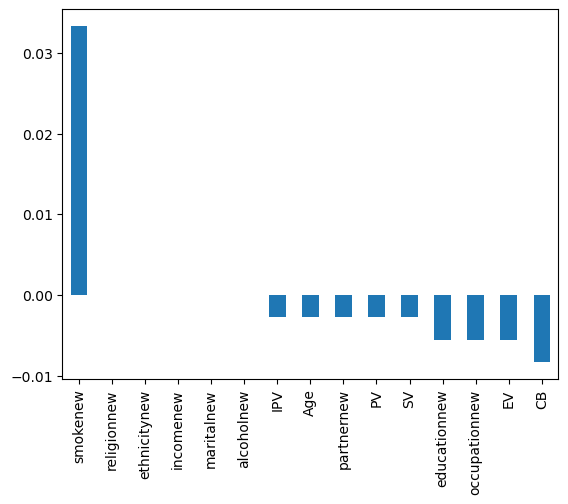

In [33]:
rf_fi = permutation_importance(rf, trn_xs, trn_y)

feature_importances = pd.Series(rf_fi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.1 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

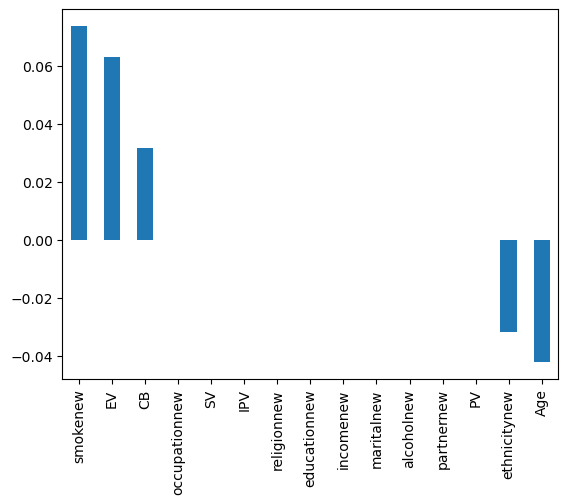

In [34]:
rf_fi_val = permutation_importance(rf, val_xs, val_y)

feature_importances = pd.Series(rf_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

> Bear in mind that this model is not considered a good model by our Evaluation above (eg. AUC Score). So we cannot say for certain that the feature importance found above has a significant value to our conclusion. However we can still take it onto our consideration for further analysis.

> Also bear in mind, we get different result each time we refresh the code due to the randomness. However I found that EV is always on top of the other feature in importance.

#### Playground To Rerun

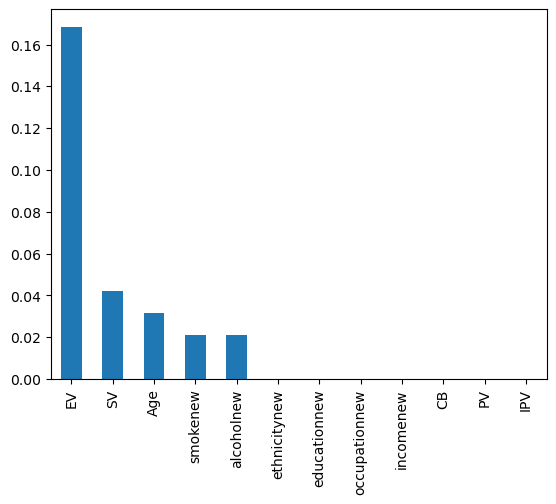

In [30]:
rf_fi_val = permutation_importance(rf, val_xs, val_y)

feature_importances = pd.Series(rf_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

### Feature Importance

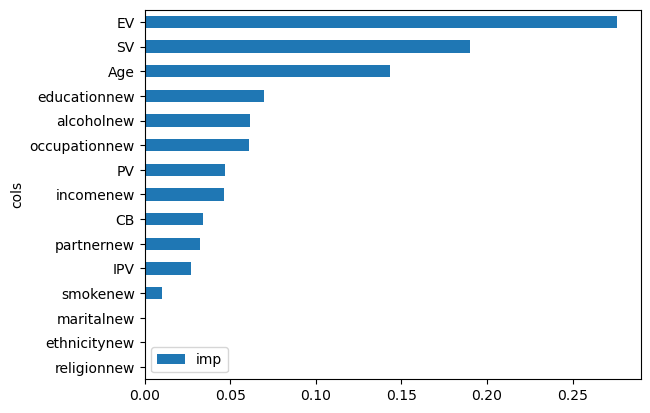

In [119]:
imp = rf.feature_importances_
pd.DataFrame(dict(cols=trn_xs.columns, imp=imp)).sort_values(by='imp', ascending=True).plot('cols', 'imp', 'barh');

> The bottom three feature is what we were expecting from the histogram where the sample is very small for one side.

### Visualizing the Results

We can use the following code to visualize our first 3 trees.

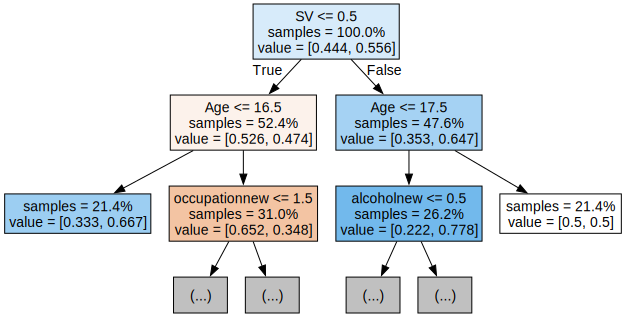

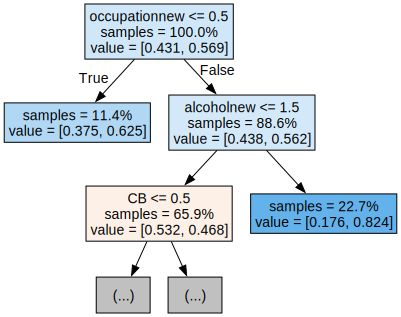

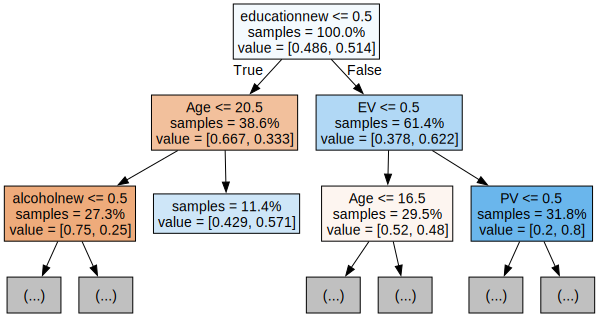

In [32]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Hyperparameter Tuning

In [131]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf2 = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf2, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(trn_xs, trn_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AA19837550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AA1ABB5D50>})

In [132]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(val_xs)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 286}


### Model Evaluation

#### MAE For Validation Set

In [133]:
mean_absolute_error(val_y, y_pred)

0.391304347826087

### MAE For Training Set

In [134]:
y_train_pred = best_rf.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.22058823529411764

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

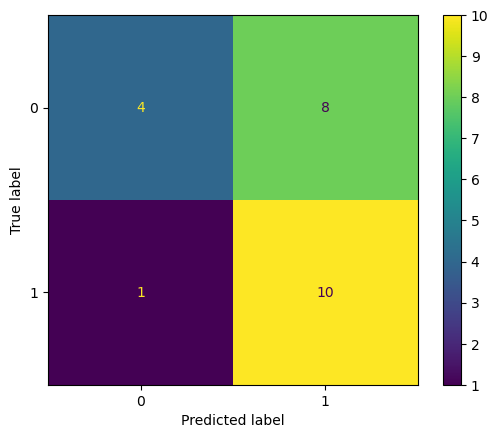

In [135]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is somewhat confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [136]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6086956521739131
Precision: 0.5555555555555556
Recall: 0.9090909090909091


### Classification Report

In [137]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

                        precision    recall  f1-score   support

without MINIdepression       0.80      0.33      0.47        12
   with MINIdepression       0.56      0.91      0.69        11

              accuracy                           0.61        23
             macro avg       0.68      0.62      0.58        23
          weighted avg       0.68      0.61      0.58        23



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

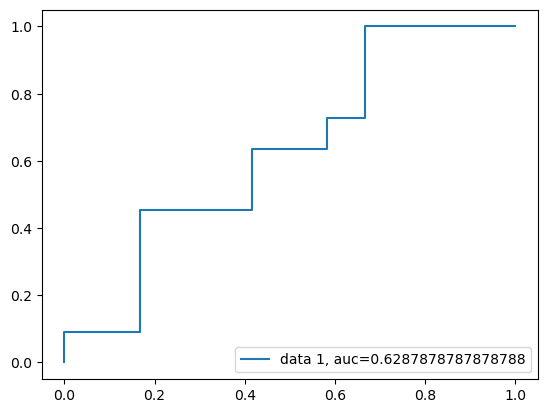

In [138]:
y_pred_proba = best_rf.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.53. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.
> This is slighly better than the Logistic Regression?

### Permutation Importance

#### By Training Set

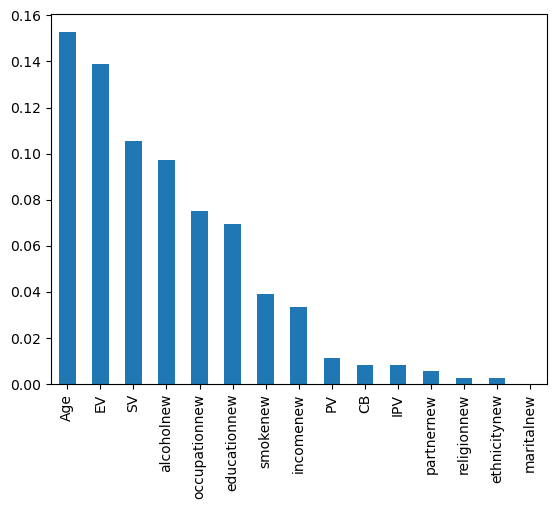

In [44]:
rf_pi = permutation_importance(best_rf, trn_xs, trn_y)

feature_importances = pd.Series(rf_pi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.16 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

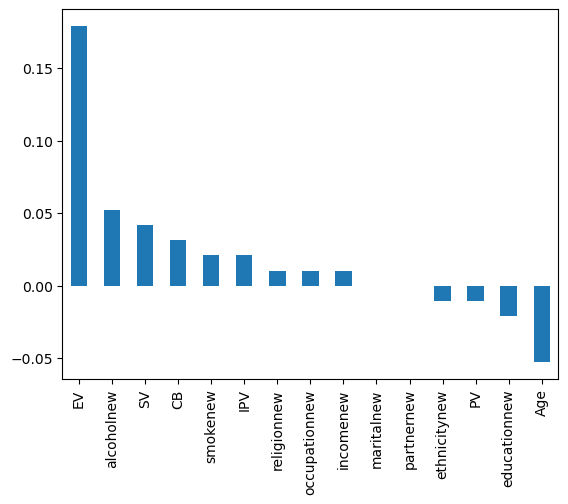

In [45]:
rf_pi_val = permutation_importance(best_rf, val_xs, val_y)

feature_importances = pd.Series(rf_pi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

### Feature Importance

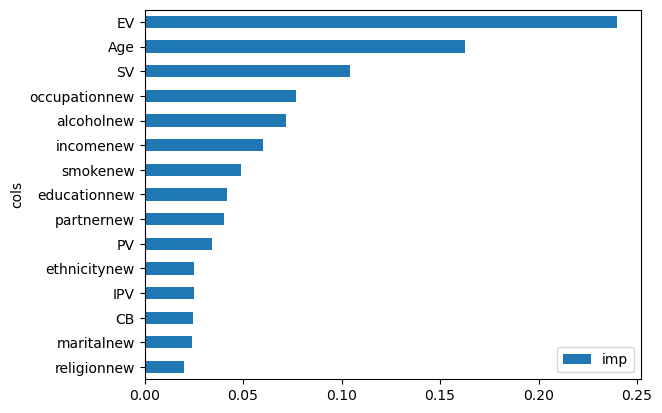

In [139]:
imp = best_rf.feature_importances_
pd.DataFrame(dict(cols=trn_xs.columns, imp=imp)).sort_values(by='imp', ascending=True).plot('cols', 'imp', 'barh');

> The bottom three feature is what we were expecting from the histogram where the sample is very small for one side.

### Visualizing the Results

We can use the following code to visualize our first 3 trees.

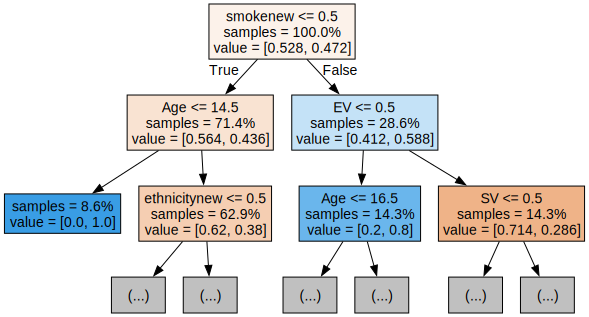

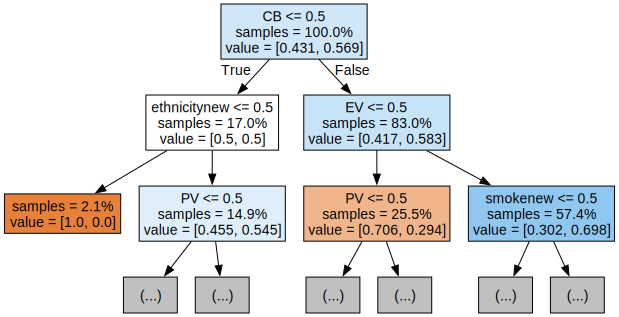

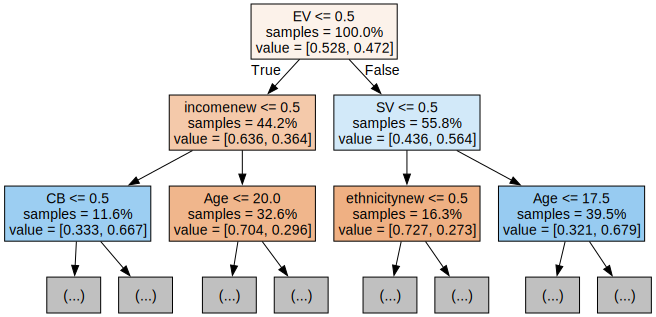

In [44]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Saving The Model

## Loading The Model

---

# Finding p-value

## Using OLS

In [120]:
sm_X, sm_Y = xs_y(df)

In [121]:
sm_X2 = sm.add_constant(sm_X)

In [122]:
est = sm.OLS(sm_Y, sm_X2)

In [123]:
est2 = est.fit()

In [124]:
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         MINIdepression   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.084
Date:                Fri, 19 Jul 2024   Prob (F-statistic):              0.386
Time:                        14:26:21   Log-Likelihood:                -56.675
No. Observations:                  91   AIC:                             145.3
Df Residuals:                      75   BIC:                             185.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9352      0.832      1.124      0.265      -0.722       2.593
religionnew      -0.1330      0.333     -0.399      0.691      -0.797       0.531
ethnicitynew     -0.0268      0.248     -0.108      0.914      -0.520       0.467
educationnew      0.1224      0.136      0.897      0.373      -0.149       0.394
occupationnew     0.0329      0.087      0.378      0.707      -0.141       0.206
incomenew        -0.0164      0.145     -0.113      0.910      -0.304       0.272
maritalnew       -0.4179      0.442     -0.945      0.348      -1.299       0.463
smokenew          0.2055      0.146      1.404      0.164      -0.086       0.497
alcoholnew       -0.0418      0.072     -0.578      0.565      -0.186       0.102
partnernew        0.1215      0.304      0.400      0.690      -0.483       0.726
EV                0.3089      0.140      2.204      0.031       0.030       0.588
CB                0.0210      0.280      0.075      0.940      -0.537       0.579
PV               -0.0560      0.140     -0.400      0.691      -0.335       0.223
SV                0.1234      0.135      0.912      0.365      -0.146       0.393
IPV              -0.1011      0.382     -0.264      0.792      -0.863       0.661
Age              -0.0172      0.018     -0.933      0.354      -0.054       0.020
==============================================================================
Omnibus:                       29.872   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.511
Skew:                          -0.014   Prob(JB):                       0.0636
Kurtosis:                       1.795   Cond. No.                         346.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Using Logistic Regression

In [151]:
sm_X, sm_Y = xs_y(df)
a = dep + ' ~ '
for label in sm_X.columns:
    a += label + ' + '

formula = 'MINIdepression ~ religionnew + ethnicitynew + educationnew + occupationnew + incomenew + maritalnew + smokenew + alcoholnew + partnernew + EV + CB + PV + SV + IPV + Age'
formula

'MINIdepression ~ religionnew + ethnicitynew + educationnew + occupationnew + incomenew + maritalnew + smokenew + alcoholnew + partnernew + EV + CB + PV + SV + IPV + Age'

In [152]:
smf_model = smf.logit(formula, data=df).fit()

Optimization terminated successfully.
         Current function value: 0.592282
         Iterations 6


In [153]:
smf_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         MINIdepression   No. Observations:                   91
Model:                          Logit   Df Residuals:                       73
Method:                           MLE   Df Model:                           17
Date:                Fri, 19 Jul 2024   Pseudo R-squ.:                  0.1394
Time:                        15:08:44   Log-Likelihood:                -53.898
converged:                       True   LL-Null:                       -62.631
Covariance Type:            nonrobust   LLR p-value:                    0.4233
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.1741      3.763      0.578      0.563      -5.202       9.550
religionnew[T.1]      -0.8905      1.669     -0.534      0.594      -4.161       2.380
ethnicitynew[T.1]     -0.1637      1.171     -0.140      0.889      -2.458       2.131
educationnew[T.1]      0.6537      0.654      0.999      0.318      -0.628       1.936
occupationnew[T.2]     0.3560      0.845      0.421      0.674      -1.301       2.013
occupationnew[T.3]     0.4060      0.838      0.484      0.628      -1.237       2.049
incomenew[T.1]        -0.0687      0.641     -0.107      0.915      -1.325       1.187
maritalnew[T.1]       -1.8696      1.992     -0.939      0.348      -5.774       2.035
smokenew[T.1]          0.9800      0.665      1.474      0.141      -0.323       2.284
alcoholnew[T.1]       -0.1795      0.730     -0.246      0.806      -1.609       1.250
alcoholnew[T.2]       -0.3560      0.670     -0.531      0.595      -1.669       0.957
partnernew[T.1]        0.5300      1.357      0.391      0.696      -2.130       3.190
EV[T.1]                1.3761      0.624      2.204      0.027       0.153       2.600
CB[T.1]               -0.0995      1.436     -0.069      0.945      -2.914       2.715
PV[T.1]               -0.2683      0.629     -0.426      0.670      -1.501       0.965
SV[T.1]                0.5843      0.604      0.967      0.333      -0.600       1.768
IPV[T.1]              -0.2618      1.808     -0.145      0.885      -3.805       3.281
Age                   -0.0763      0.085     -0.894      0.371      -0.244       0.091
======================================================================================
"""

---

# FastAI Tabular Learner

## Model Training and Prediction

In [52]:
from fastai.tabular.all import *

In [53]:
splits = RandomSplitter()(df)

In [54]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cats,
    cont_names=conts,
    y_names=dep, y_block=CategoryBlock(),
).dataloaders(path='.')

In [81]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.12022644281387329, valley=0.004365158267319202)

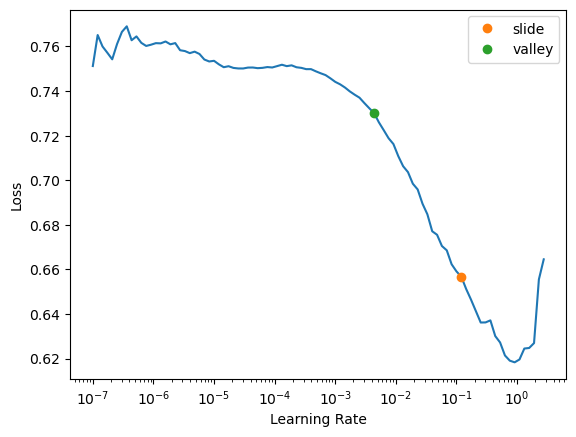

In [56]:
learn.lr_find(suggest_funcs=(slide, valley))

In [84]:
learn.fit(10, lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.634044,0.683321,0.555556,00:00
1,0.648154,0.683280,0.555556,00:00
2,0.637193,0.682940,0.555556,00:00
3,0.644638,0.682439,0.666667,00:00
4,0.632519,0.682550,0.722222,00:00
5,0.643019,0.682262,0.722222,00:00
6,0.655556,0.681732,0.722222,00:00
7,0.645784,0.681673,0.777778,00:00
8,0.647675,0.681233,0.666667,00:00
9,0.642916,0.680949,0.666667,00:00


In [85]:
trn_split,val_split=splits

In [86]:
df.iloc[val_split]

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,Smoking,Alcohol,Partner,P_Age,P_Education,P_Occupation,P_Alcohol,P_Drugs,P_Fights,P_Women,P_Child,SectionCQ1,SectionCQ2,SectionCQ3,SectionCQ4,SectionCQ5,SectionCQ6,SectionCQ7,SectionCQ8,SectionCQ9,SectionCQ10,SectionCQ11,SectionCQ12,SectionCQ13,SectionCQ14,SectionCQ15,SectionCQ16,SectionCQ17,SectionCQ18,SectionCQ19,SectionCQ20,SectionCQ21,SectionCQ22,SectionCQ23,SectionCQ24,SectionCQ25,SectionCQ26,SectionCQ27,SectionCQ28,SectionCQ29,SectionCQ30,SectionCQ31,SectionCQ32,SectionCQ33,SectionCQ34,SectionCQ35,SectionCQ36,SectionCQ37,SectionCQ38,SectionCQ39,SectionCQ40,SectionCQ41,SectionCQ42,SectionCQ43,SectionCQ44,SectionDQ1,SectionDQ1a,SectionDQ2,SectionDQ2a,SectionDQ3,SectionDQ3a,SectionDQ4,SectionDQ5,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,PHQ10,TPHQ,LDEPRESSION,PDEPRESSION,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,TANXIETY,Lanxiety,Panxiety,PCL1,PCL2,PCL3,PCL4,PCL5,PCL6,PCL7,PCL8,PCL9,PCL10,PCL11,PCL12,PCL13,PCL14,PCL15,PCL16,PCL17,PCL18,PCL19,PCL20,TPCL,PPTSD,MINI1,MINI1a,MINI2,MINI2a,MINI3,MINI4,MINI5,MINI6,MINI7,MINI8,MINI9,MINI10,MINI11,MINIdepression,EV,CB,PV,SV,IPV,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
8,1,1,17,1,1,2,4,2,1,1,1,7,5,16,1,1,5,5,2,2,2,2,2,1,2,4,2,2,1,2,1,2,1,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,2,3,3,4,4,4,4,5,2,,2,,2,,2,1,1,3,3,3,2,3,0,3,3,3,21,5,1,0,0,0,0,0,2,3,5,2,0,0,0,3,0,0,0,0,3,0,0,4,4,0,0,0,0,0,0,0,4,18,0,1,1,1,1,1,1,1,1,1,1,1,2,1,1,0,1,0,1,1,1,1,1,0,1,1,3,1,0,1
37,52,1,20,1,1,3,2,1,1,3,3,7,2,19,3,4,5,5,3,3,2,3,3,1,1,3,2,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,1,1,2,3,2,3,1,1,2,3,1,1,2,2,2,2,1,1,1,1413,2,,2,,1,1,1,2,3,3,3,2,0,0,0,1,14,3,0,1,2,3,2,1,1,3,13,3,1,2,2,3,3,1,1,1,1,2,1,2,1,3,1,0,0,0,0,0,0,24,0,2,,2,,2,1,1,2,2,2,2,2,2,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1
62,61,1,14,1,1,2,4,1,1,3,2,2,1,21,2,1,3,5,1,1,2,3,2,1,1,2,1,2,1,2,1,1,1,1,3,2,3,1,,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,2,2,2,2,3,3,3,3,4,1,8,1,710,1,7,2,2,2,3,1,2,1,1,0,1,2,2,13,3,0,3,3,3,2,2,3,3,19,4,1,3,1,2,2,1,2,3,1,2,3,4,4,4,4,2,2,2,4,3,1,50,1,2,,2,,,,,,,,,,,0,1,1,0,0,1,1,1,1,1,1,1,3,0,2,1
51,53,1,19,1,1,3,1,1,1,3,3,7,1,20,2,1,4,4,1,3,2,1,1,1,1,3,1,2,1,1,1,1,1,1,2,1,2,2,3,1,2,2,3,2,3,2,3,2,3,2,3,2,3,1,2,1,2,1,2,2,3,3,2,2,1,1,9,2,,2,,2,2,1,3,3,3,3,3,3,3,3,1,25,5,1,0,1,1,1,1,0,0,4,1,0,0,0,0,2,1,1,1,2,3,2,2,4,4,2,1,0,2,2,2,3,34,0,1,2,1,1,2,1,2,2,1,1,2,2,2,0,1,1,0,1,1,1,1,1,1,1,0,2,0,0,1
40,62,1,14,1,1,2,4,1,1,3,2,7,1,19,2,1,6,6,1,1,4,1,1,1,1,3,1,2,1,1,1,1,1,1,2,2,2,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,2,3,1,2,3,4,4,4,4,5,1,410,2,,2,,2,1,3,3,3,3,3,3,3,3,3,3,27,5,1,3,3,3,3,3,2,3,20,4,1,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,76,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,3,0,0,1
22,24,1,12,1,4,1,1,2,1,1,1,6,1,18,2,1,1,1,1,2,2,1,1,1,1,4,2,2,2,2,2,2,1,1,1,2,3,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,1,2,,2,,1,1,1,2,2,2,2,2,2,2,1,1,16,4,0,3,1,3,3,3,3,3,19,4,1,4,1,4,4,4,4,4,4,4,4,4,0,4,4,4,2,2,2,4,4,67,1,1,1,2,,2,1,1,1,1,2,1,1,1,1,1,1,0,0,1,1,1,0,0,1,0,2,1,1,1
53,57,1,16,1,1,2,4,1,1,3,3,7,3,20,4,1,5,5,2,2,2,1,1,3,1,1,2,1,1,2,1,2,1,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,7,1,7,1,10,1,1,1,1,0,3,0,0,0,0,1,1,6,2,0,3,2,0,0,1,0,0,6,2,0,2,0,3,2,0,1,2,1,0,1,2,3,2,0,1,2,0,1,1,0,24,0,2,,2,,2,2,2,2,2,2,1,2,2,0,0,1,0,0,1,1,1,1,1,1,1,3,0,0,1
12,3,1,16,3,3,1,4,1,1,2,2,6,5,17,3,1,2,5,1,2,2,1,1,1,1,3,2,2,2,2,1,2,1,1,2,1,2,1,2,1,2,1,2,1,2,1,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,3,3,3,4,1,13710,1,23710,1,2378,3,1,3,3,1,2,1,2,0,0,1,3,13,3,0,0,2,2,2,3,3,3,15,4,1,2,4,2,4,4,4,3,2,4,3,4,4,4,4,4,4,2,4,4,2,68,1,1,1,1,1,2,1,2,2,1,1,2,2,1,1,1,1,1,0,1,1,0,0,1,1,0,3,1,1,1
17,70,2,16,1,1,2,4,1,1,3,3,7,1,17,2,4,6,6,3,4,2,1,1,1,3,3,1,2,1,2,1,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,2,3,2,3,3,3,3,4,2,14,2,14,2,14,2,2,1,2,2,1,3,2,3,2,2,1,18,4,0,2,1,1,3,3,3,2,15,4,1,1,1,1,3,2,3,2,1,1,3,2,2,1,1,4,1,2,2,1,2,36,1,2,2,2,2,2,2,1,2,1,2,2,1,2,0,0,1,0,1,1,1,1,1,1,1,1,3,0,0,1
48,40,1,17,1,1

In [87]:
tst_dl = learn.dls.test_dl(df.iloc[val_split])

In [89]:
y_prob_ai, val_y_ai, y_pred_ai  = learn.get_preds(dl=tst_dl, with_decoded=True)

## Model Evaluation

### MAE For Validation Set

In [90]:
mean_absolute_error(val_y_ai, y_pred_ai)

0.3333333333333333

### MAE For Training Set

In [91]:
training_dl = learn.dls.test_dl(df.iloc[trn_split])
y_train_prob_ai, train_y_ai, y_train_pred_ai  = learn.get_preds(dl=training_dl, with_decoded=True)
mean_absolute_error(train_y_ai, y_train_pred_ai)

0.3561643835616438

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

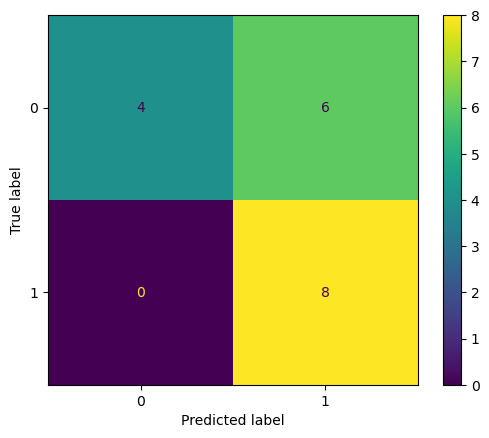

In [92]:
# Create the confusion matrix
cm = confusion_matrix(val_y_ai, y_pred_ai)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is fairly confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [93]:
accuracy = accuracy_score(val_y_ai, y_pred_ai)
precision = precision_score(val_y_ai, y_pred_ai)
recall = recall_score(val_y_ai, y_pred_ai)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6666666666666666
Precision: 0.5714285714285714
Recall: 1.0


Accuracy: In general, when the model makes prediction, it is right 63% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

In this case, with 100% precision, means for all those that this model predict as depressed, it is precisely all of them really are depressed. But with low recall meaning our model is missing (in this case 42%) other patients who are depressed but failed to be detected by our model.

### Classification Report

In [94]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y_ai, y_pred_ai, target_names=target_names))

                        precision    recall  f1-score   support

without MINIdepression       1.00      0.40      0.57        10
   with MINIdepression       0.57      1.00      0.73         8

              accuracy                           0.67        18
             macro avg       0.79      0.70      0.65        18
          weighted avg       0.81      0.67      0.64        18



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

## Saving The Model

## Load The Model

---